### Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Load Feature-Engineered Dataset

In [ ]:
df = pd.read_csv("electricity_demand_features.csv")
df.head()

,day,hour,time_normalized,sin_time,cos_time,temp,is_weekend,measured_demand
0,0,0.0,0.000000,0.000000,1.000000,25.745071,0,2.904928
1,0,0.5,0.020833,0.130526,0.991445,25.836813,0,3.321722
2,0,1.0,0.041667,0.258819,0.965926,28.042085,0,3.488050
3,0,1.5,0.062500,0.382683,0.923880,30.346012,0,3.534498
4,0,2.0,0.083333,0.500000,0.866025,28.648770,0,4.059016


### Sort Data in temporal order

In [ ]:
df = df.sort_values(["day", "hour"]).reset_index(drop=True)

### Select Features for Time Series

In [ ]:
features = ["measured_demand", "temp", "is_weekend"]
data = df[features].values

### Normalize Features

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

### Create Sequences Function

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])  # demand
    return np.array(X), np.array(y)

### Generate LSTM Sequences

In [ ]:
WINDOW_SIZE = 24  # 12 hours (30-min resolution)

X, y = create_sequences(data_scaled, WINDOW_SIZE)

X.shape, y.shape

((1416, 24, 3), (1416,))

### Train-Test Split (Time-Based)

In [ ]:
split_index = int(0.75 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

### Build LSTM Model

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

### Train LSTM Model

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1191 - val_loss: 0.0282
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0312 - val_loss: 0.0132
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0160 - val_loss: 0.0071
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0129 - val_loss: 0.0053
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0105 - val_loss: 0.0043
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

### Training Loss Curve

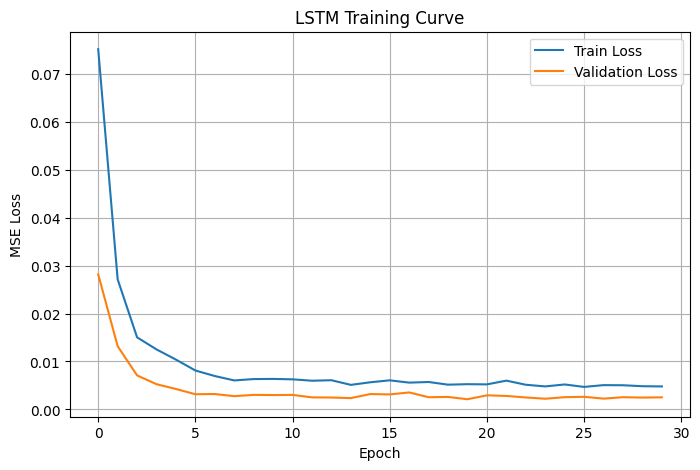

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Curve")
plt.legend()
plt.grid(True)
plt.show()

### Model Evaluation

In [ ]:
y_pred = model.predict(X_test)

mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

mse_lstm, r2_lstm

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


(0.002533968886520984, 0.9554717724302474)

### Inverse Scaling for Interpretation

In [ ]:
def inverse_demand(y_scaled, data, scaler):
    temp = np.zeros((len(y_scaled), data.shape[1]))
    temp[:, 0] = y_scaled.flatten()
    return scaler.inverse_transform(temp)[:, 0]

y_test_inv = inverse_demand(y_test, data_scaled, scaler)
y_pred_inv = inverse_demand(y_pred, data_scaled, scaler)

### Forecast Visualization

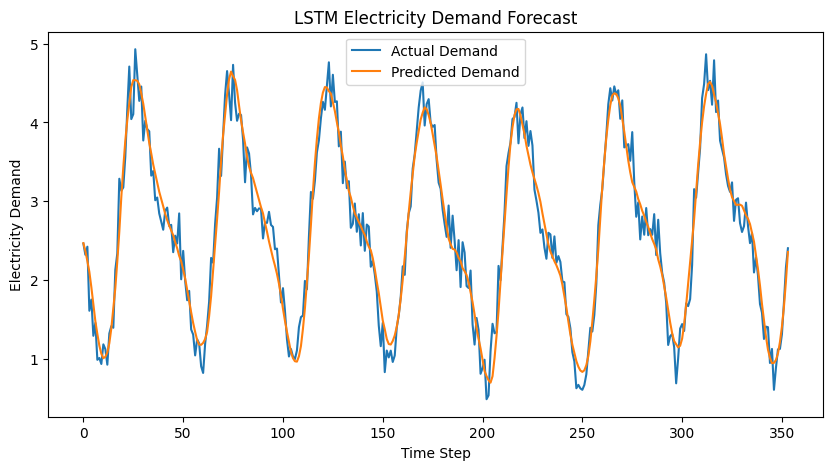

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(y_test_inv, label="Actual Demand")
plt.plot(y_pred_inv, label="Predicted Demand")

plt.xlabel("Time Step")
plt.ylabel("Electricity Demand")
plt.title("LSTM Electricity Demand Forecast")
plt.legend()
plt.show()

### Residual Analysis

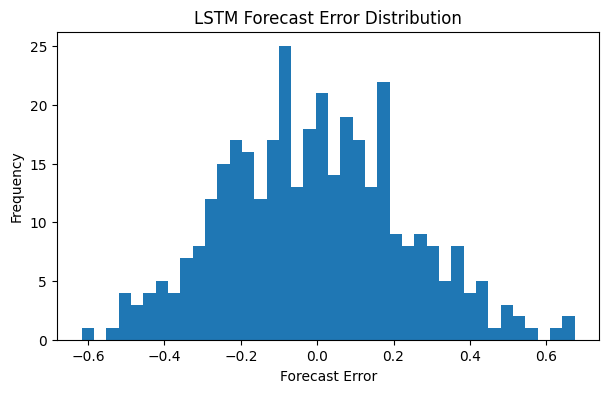

In [ ]:
errors = y_test_inv - y_pred_inv

plt.figure(figsize=(7, 4))
plt.hist(errors, bins=40)
plt.xlabel("Forecast Error")
plt.ylabel("Frequency")
plt.title("LSTM Forecast Error Distribution")
plt.show()

### Model Comparison Summary

In [ ]:
print("Model Performance Summary")
print("-" * 40)
print(f"LSTM MSE : {mse_lstm:.4f}")
print(f"LSTM R²  : {r2_lstm:.4f}")

print("\nObservation:")
print("LSTM captures temporal dependencies unavailable to tabular models.")

Model Performance Summary
----------------------------------------
LSTM MSE : 0.0025
LSTM R²  : 0.9555

Observation:
LSTM captures temporal dependencies unavailable to tabular models.


### Summary

- Sequence-based learning captures temporal patterns
- Uses past demand to predict future demand
- Outperforms MLP when temporal dependency is strong
- Suitable for real-world load forecasting